In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import yfinance as yf
from backtesting import Backtest, Strategy

Loading BokehJS ...

In [3]:
df = yf.Ticker('SPY').history(interval ='15m' , period ='60d')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1541 entries, 2023-12-08 09:30:00-05:00 to 2024-03-06 11:00:00-05:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           1541 non-null   float64
 1   High           1541 non-null   float64
 2   Low            1541 non-null   float64
 3   Close          1541 non-null   float64
 4   Volume         1541 non-null   int64  
 5   Dividends      1541 non-null   float64
 6   Stock Splits   1541 non-null   float64
 7   Capital Gains  1541 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 108.4 KB


In [4]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Datetime,,,,,,,,
2023-12-08 09:30:00-05:00,457.760101,458.670013,457.230011,458.640015,5584734,0.0,0.0,0.0
2023-12-08 09:45:00-05:00,458.649994,458.739990,457.940002,458.200012,2918216,0.0,0.0,0.0
2023-12-08 10:00:00-05:00,458.600006,459.940002,458.220001,459.920013,3995086,0.0,0.0,0.0
2023-12-08 10:15:00-05:00,459.920013,460.420013,459.790009,459.859985,2984409,0.0,0.0,0.0
2023-12-08 10:30:00-05:00,459.859985,459.970001,458.579987,458.940002,2949117,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-03-06 10:00:00-05:00,509.899994,509.940002,508.420013,509.149994,2392166,0.0,0.0,0.0
2024-03-06 10:15:00-05:00,509.140015,509.799988,509.070007,509.359985,1784287,0.0,0.0,0.0
2024-03-06 10:30:00-05:00,509.350006,510.000000,509.040009,509.649994,13608172,0.0,0.0,0.0


In [5]:
def MA(price,period) :
    return pd.Series(price).rolling(period).mean()

In [6]:
MA(df.Close,3)

Datetime
2023-12-08 09:30:00-05:00           NaN
2023-12-08 09:45:00-05:00           NaN
2023-12-08 10:00:00-05:00    458.920013
2023-12-08 10:15:00-05:00    459.326670
2023-12-08 10:30:00-05:00    459.573334
                                ...    
2024-03-06 10:00:00-05:00    509.738332
2024-03-06 10:15:00-05:00    509.473328
2024-03-06 10:30:00-05:00    509.386658
2024-03-06 10:45:00-05:00    509.821655
2024-03-06 11:00:00-05:00    510.371663
Name: Close, Length: 1541, dtype: float64

In [7]:
### backtest MA-cross over

class MAcross(Strategy) :
    n1 = 12
    n2 = 26
    def init(self) :
        close = self.data.Close
        self.ma_short = self.I(MA , close , self.n1)
        self.ma_long  = self.I(MA , close , self.n2)
    def next(self) :
        if self.ma_short[-2] < self.ma_long[-2] :
            if self.ma_short[-1] > self.ma_long[-1] :
                self.buy()
        elif self.ma_short[-2] > self.ma_long[-2] :
            if self.ma_short[-1] < self.ma_long[-1] :
                if self.position :
                    self.position.close()

bt = Backtest(df, MAcross,
              cash=10000, commission=.002,
              exclusive_orders=True)

output_MA = bt.run()
bt.plot()

Row(id='1450', ...)

In [8]:
output_MA

Start                     2023-12-08 09:30...
End                       2024-03-06 11:00...
Duration                     89 days 01:30:00
Exposure Time [%]                   56.391953
Equity Final [$]                   9967.92498
Equity Peak [$]                  10071.938516
Return [%]                           -0.32075
Buy & Hold Return [%]                11.41854
Return (Ann.) [%]                   -1.340254
Volatility (Ann.) [%]                7.255715
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -3.250411
Avg. Drawdown [%]                   -0.649113
Max. Drawdown Duration       57 days 03:00:00
Avg. Drawdown Duration        8 days 18:34:00
# Trades                                   30
Win Rate [%]                        33.333333
Best Trade [%]                       1.827435
Worst Trade [%]                     -1.016966
Avg. Trade [%]                    

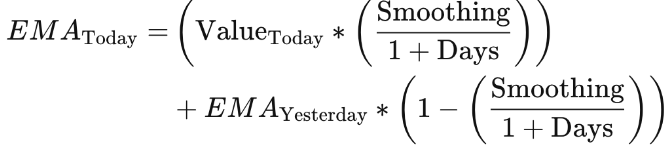

In [9]:
def EMA(price, period, smoothing=2):

    ema_values = [sum(price[:period]) / period]
    
    for i in price[period:]:
        ema_values.append((i * (smoothing / (1 + period))) + ema_values[-1] * (1 - (smoothing / (1 + period))))
        
    return pd.Series(ema_values, index=price.index[period-1:])
     

In [10]:
EMA(df.Close,3, smoothing=2)

2023-12-08 10:00:00-05:00    458.920013
2023-12-08 10:15:00-05:00    459.389999
2023-12-08 10:30:00-05:00    459.165001
2023-12-08 10:45:00-05:00    459.587505
2023-12-08 11:00:00-05:00    459.263754
                                ...    
2024-03-06 10:00:00-05:00    509.111558
2024-03-06 10:15:00-05:00    509.235772
2024-03-06 10:30:00-05:00    509.442883
2024-03-06 10:45:00-05:00    509.948935
2024-03-06 11:00:00-05:00    510.479472
Length: 1539, dtype: float64